# Modelo 2

### modelo de Computação evolucionária para prever a série temporal

In [365]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn import feature_extraction,model_selection,multioutput
from pandas.plotting import autocorrelation_plot
#from sklearn.ensemble import RandomForestRegressor
#from sklearn.metrics import r2_score

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

In [366]:
df = pd.read_csv('DailyDelhiClimateTrain.csv')
df_test = pd.read_csv('DailyDelhiClimateTest.csv')
df.info(), df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          1462 non-null   object 
 1   meantemp      1462 non-null   float64
 2   humidity      1462 non-null   float64
 3   wind_speed    1462 non-null   float64
 4   meanpressure  1462 non-null   float64
dtypes: float64(4), object(1)
memory usage: 57.2+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          114 non-null    object 
 1   meantemp      114 non-null    float64
 2   humidity      114 non-null    float64
 3   wind_speed    114 non-null    float64
 4   meanpressure  114 non-null    float64
dtypes: float64(4), object(1)
memory usage: 4.6+ KB


(None, None)

In [367]:
df['date'] = pd.to_datetime(df['date'])#, format='%d.%m.%Y %H:%M:%S')
df = df.set_index('date')

df_test['date'] = pd.to_datetime(df_test['date'])#, format='%d.%m.%Y %H:%M:%S')
df_test = df_test.set_index('date')

{'whiskers': [<matplotlib.lines.Line2D at 0x219f220ddc0>,
 'caps': [<matplotlib.lines.Line2D at 0x219f220e390>,
 'boxes': [<matplotlib.lines.Line2D at 0x219f220db20>],
 'medians': [<matplotlib.lines.Line2D at 0x219f220e930>],
 'fliers': [],
 'means': []}

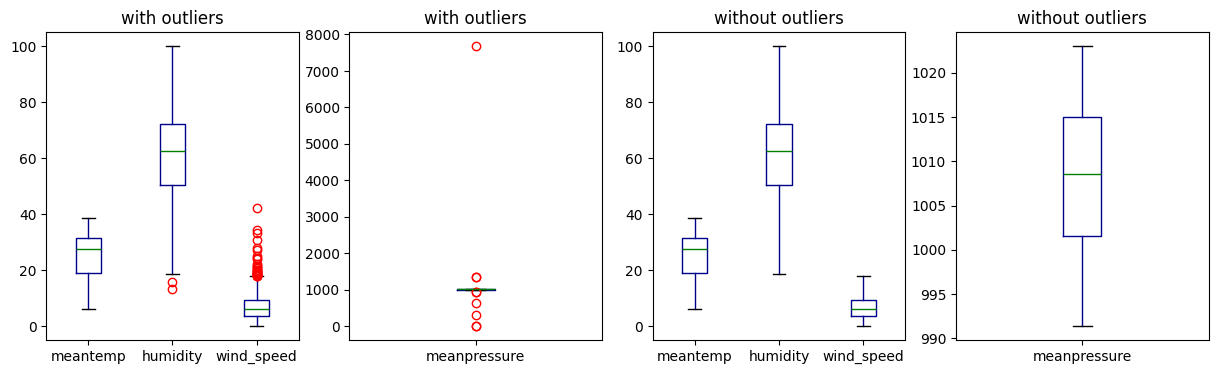

In [368]:
fig, (ax11,ax12,ax21,ax22) = plt.subplots(1,4,figsize=(15,4))
cl1 = df[list(df.columns)[:-1]]
cl2 = df[list(df.columns)[-1:]]
#plt.boxplot(cl1,)
ax11.set_title("with outliers")
ax11.boxplot(cl1, boxprops=dict(color='darkblue'),capprops=dict(color='black'),whiskerprops=dict(color='darkblue'),
flierprops=dict(color='cyan',markeredgecolor='red'),medianprops=dict(color='green'),labels=cl1.columns,showfliers=True)

ax12.set_title("with outliers")
ax12.boxplot(cl2,boxprops=dict(color='darkblue'),capprops=dict(color='black'),whiskerprops=dict(color='darkblue'),
flierprops=dict(color='cyan', markeredgecolor='red'),medianprops=dict(color='green'),labels=cl2.columns,showfliers=True)

ax21.set_title("without outliers")
ax21.boxplot(cl1, boxprops=dict(color='darkblue'),capprops=dict(color='black'),whiskerprops=dict(color='darkblue'),
flierprops=dict(color='cyan',markeredgecolor='red'),medianprops=dict(color='green'),labels=cl1.columns,showfliers=False)

ax22.set_title("without outliers")
ax22.boxplot(cl2,boxprops=dict(color='darkblue'),capprops=dict(color='black'),whiskerprops=dict(color='darkblue'),
flierprops=dict(color='cyan', markeredgecolor='red'),medianprops=dict(color='green'),labels=cl2.columns,showfliers=False)

#ax1.boxplot(df[list(df.columns)[:-1]],showfliers=False)
#ax2.boxplot(df[list(df.columns)[-1]],showfliers=False)

#df[list(df.columns)[:-1]].boxplot(showfliers=False)

In [369]:
def remove_outliers(df):
    Q1 = df['meanpressure'].quantile(0.25)
    Q3 = df['meanpressure'].quantile(0.75)
    IQR = Q3 - Q1

    filter = (df['meanpressure'] >= Q1 - 1.5 * IQR) & (df['meanpressure'] <= Q3 + 1.5 *IQR)
    df = df.loc[filter]
    return df
df = remove_outliers(df)
df_test = remove_outliers(df_test)

array([<Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>], dtype=object)

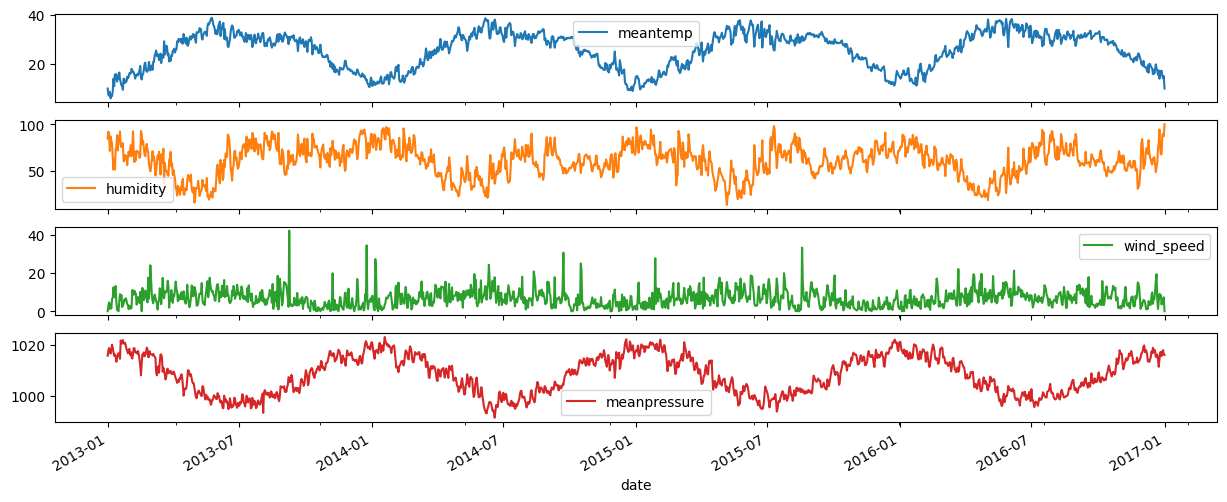

In [370]:
df.plot(subplots=True)

```python
#código para comparar quartil com z-score
sml2 = df[
    #(np.abs(stats.zscore(df)) < 3).all(axis=1)
    (np.abs(stats.zscore(df.meanpressure)) < 0.359)
]
sml2.plot(subplots=True)
diff_size1 = pd.concat([df,sml2]).drop_duplicates(keep=False)
if diff_size1.__len__() == 0:
    print("nenhuma diferença no corte dos outliers em meantemperature")
else:
    print(diff_size1)
```

```python
import pmdarima as pm
from pmdarima.model_selection import train_test_split

from pmdarima.arima import auto_arima
from pmdarima import arima
from pmdarima.utils import tsdisplay, autocorr_plot, decomposed_plot, plot_acf, plot_pacf
from matplotlib.pyplot import rcParams
rcParams['figure.figsize']=15,6
from pmdarima.arima import ADFTest
from statsmodels.tsa.statespace.sarimax import SARIMAX
```

In [371]:
df.index = pd.DatetimeIndex(df.index).to_period('d')
df_test.index = pd.DatetimeIndex(df_test.index).to_period('d')

#Split the data into training and test sets
train, test = train_test_split(df, train_size=0.75)

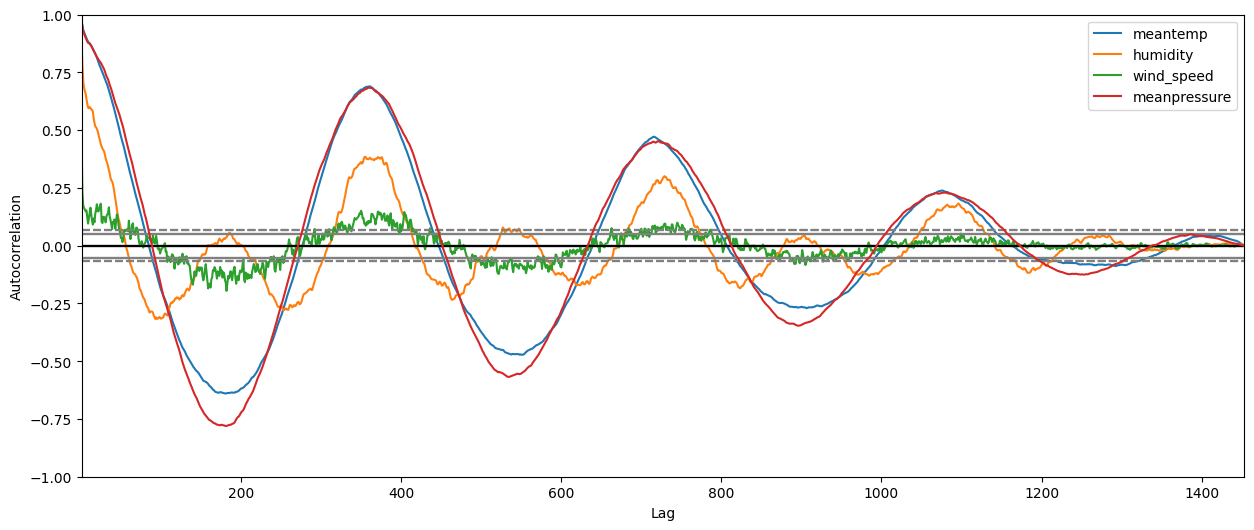

In [372]:
for x in df.columns:
    autocorrelation_plot(df[x],label=x)
    plt.legend()

In [373]:
model = ARIMA(endog=df['meantemp'],exog=df.drop(['meantemp'],axis=1))
res = model.fit()
#model.fit(df_test, df)

d:\PROGRA~1\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [374]:
df_test.index[0]

Period('2017-01-02', 'D')

In [375]:
forecast = res.forecast(steps=df_test.__len__(),exog=df_test.drop(['meantemp'],axis=1))
#forecast = res.predict(steps=7)

#mse = np.mean((forecast - df_test) ** 2)

In [376]:
#forecast.index = df_test.index

In [377]:
print(df.index.min()," -> ",df.index.max())
print(df_test.index.min()," -> ",df_test.index.max())
print(forecast.index.min()," -> ",forecast.index.max())

2013-01-01  ->  2017-01-01
2017-01-02  ->  2017-04-24
2016-12-24  ->  2017-04-15


PeriodIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
             '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
             '2013-01-09', '2013-01-10',
             ...
             '2016-12-23', '2016-12-24', '2016-12-25', '2016-12-26',
             '2016-12-27', '2016-12-28', '2016-12-29', '2016-12-30',
             '2016-12-31', '2017-01-01'],
            dtype='period[D]', name='date', length=1453)

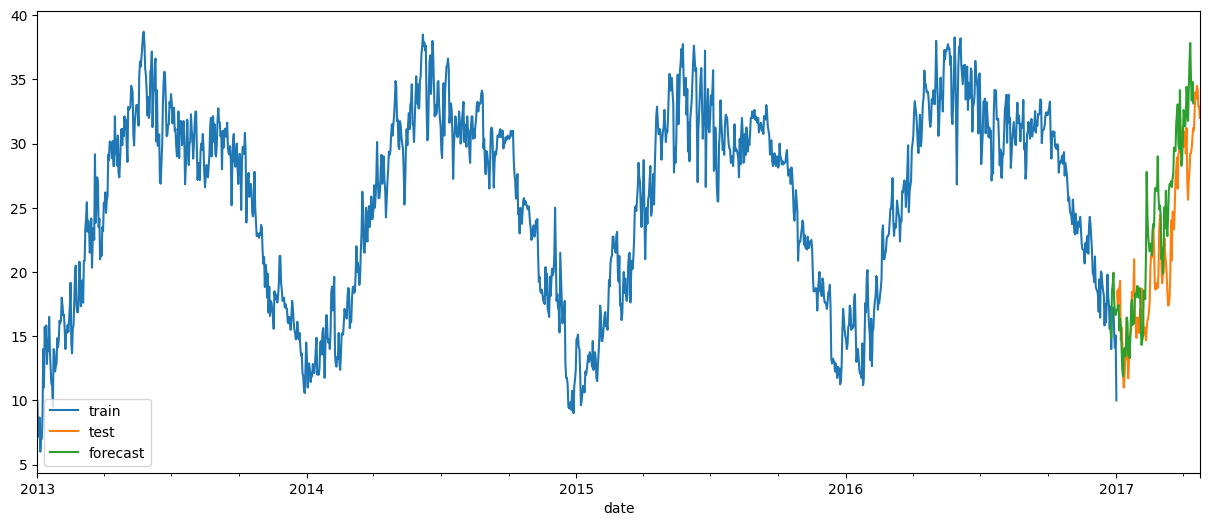

In [391]:
df.meantemp.plot(label='train')
df_test.meantemp.plot(label='test')
forecast.plot(label='forecast')
plt.legend()
#plt.plot(df.humidity.index,df.humidity.values)
#plt.plot(df_test.humidity)
#plt.plot(forecast.values)
#plt.show()